In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.sparse import csr_matrix
import os

In [2]:
test = pd.read_csv('UNSW_NB15_testing-set.csv')
train = pd.read_csv('UNSW_NB15_training-set.csv')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0


In [5]:
train['service'] = train['service'].apply(lambda x:'None' if x == '-' else x)

In [6]:
# Dropping columns which are not useful for the classification
# attack_cat is for multiclass classification
train.drop(['attack_cat'], axis=1, inplace=True)

In [7]:
train.duplicated().sum()

0

In [8]:
train['network_bytes'] = train['sbytes'] + train['dbytes']

In [9]:
train_coeff_df = train.copy()

In [10]:
train_coeff_df['proto'] = train_coeff_df['proto'].astype('category').cat.codes
train_coeff_df['service'] = train_coeff_df['service'].astype('category').cat.codes
train_coeff_df['state'] = train_coeff_df['state'].astype('category').cat.codes

In [11]:
train_coeff_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,network_bytes
0,1,0.121478,113,0,2,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,0,430
1,2,0.649902,113,0,2,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,0,42748
2,3,1.623129,113,0,2,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,0,13550
3,4,1.681642,113,3,2,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,0,1398
4,5,0.449454,113,0,2,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,0,802


In [12]:
train_coeff = train_coeff_df.corr()

In [13]:
upper = train_coeff.where(np.triu(np.ones(train_coeff.shape),k=1).astype(bool))

<Axes: >

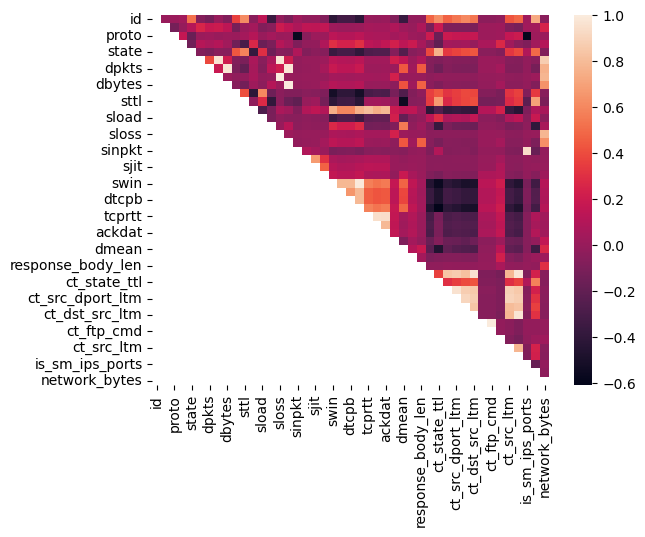

In [14]:
sns.heatmap(upper)

In [15]:
upper.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'label', 'network_bytes'],
      dtype='object')

In [16]:
drop = []
for column in upper.columns:
    if any(upper[column] > 0.95):
        drop.append(column)

drop = [columns for columns in upper.columns if any(upper[columns] > 0.95)]

In [17]:
drop

['sbytes',
 'dbytes',
 'sloss',
 'dloss',
 'dwin',
 'ct_src_dport_ltm',
 'ct_dst_src_ltm',
 'ct_ftp_cmd',
 'ct_srv_dst']

In [18]:
train.drop(drop, axis=1, inplace=True)

In [19]:
train.shape

(175341, 36)

In [20]:
saved_dict = {}
saved_dict['cat_columns'] = ['service','proto','state']
saved_dict['numerical_columns'] = list(set(train.columns) - set(['service','proto','state']))
saved_dict['Dropped_col'] = drop + ['attack_cat']

In [21]:
def multi_corr(col1,col2='label',df=train):
    corr = df[[col1,col2]].corr().iloc[0,1]
    log_corr = df[col1].apply(np.log1p).corr(df[col2])
    print(f'--------------{col1}--------------\n correaltion = {corr} \n correlation of log = {log_corr}')

In [22]:
for column in list(set(train.columns) - set(saved_dict['cat_columns'])):
    multi_corr(column)

--------------response_body_len--------------
 correaltion = -0.021361349813297067 
 correlation of log = -0.06738634977170314
--------------dload--------------
 correaltion = -0.3937393736073813 
 correlation of log = -0.6250180335766263
--------------ackdat--------------
 correaltion = 0.09736393873378867 
 correlation of log = 0.10724075023803974
--------------ct_dst_ltm--------------
 correaltion = 0.22988728781105236 
 correlation of log = 0.1461909074099689
--------------dinpkt--------------
 correaltion = -0.022887477717625563 
 correlation of log = -0.02580529721279208
--------------network_bytes--------------
 correaltion = -0.03429600864712312 
 correlation of log = -0.390495838572496
--------------sload--------------
 correaltion = 0.18286965908056504 
 correlation of log = 0.3222502550876712
--------------ct_src_ltm--------------
 correaltion = 0.2382250786953459 
 correlation of log = 0.16445368070044544
--------------dmean--------------
 correaltion = -0.3418063059609559 

In [23]:
log_transform_cols = [
    'dmean', 'spkts', 'dpkts', 'network_bytes', 'sjit', 'djit',
    'stcpb', 'sload', 'dttl', 'dload', 'rate'
]
saved_dict['log_transformed'] = log_transform_cols

In [24]:
for column in log_transform_cols:
    train[column+'_log1p'] = train[column].apply(np.log1p)
    train.drop(columns = column, inplace = True)

**SCALING**

In [26]:
x_train = train.drop(columns=['label'],axis = 1).copy()
y_train = train['label']

In [27]:
xtrain,xval,ytrain,yval = train_test_split(x_train,y_train,test_size = 0.25,random_state = 42, stratify = y_train)

In [28]:
scaler_dict = {}

In [29]:
for column in list(set(x_train.columns) - set(saved_dict['cat_columns'])):
    scaler = StandardScaler()
    scaler.fit(x_train[[column]])
    x_train[column] = scaler.transform(x_train[[column]])
    scaler_dict[column] = scaler

In [30]:
saved_dict['scalers'] = scaler_dict

In [31]:
x_train.shape

(175341, 35)

In [32]:
x_train.head()

,id,dur,proto,service,state,sttl,sinpkt,dinpkt,swin,dtcpb,tcprtt,synack,ackdat,smean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,dmean_log1p,spkts_log1p,dpkts_log1p,network_bytes_log1p,sjit_log1p,djit_log1p,stcpb_log1p,sload_log1p,dttl_log1p,dload_log1p,rate_log1p
0,-1.732041,-0.191029,tcp,None,FIN,0.703839,-0.132788,-0.080885,1.092456,0.911123,-0.521660,-0.484346,-0.503014,-0.458048,-0.136415,-0.039557,-0.775991,-1.366486,-0.645013,-0.554373,-0.118590,-0.189768,-0.715714,-0.126508,0.506480,-0.068307,0.140261,-0.350206,-0.010753,0.104541,1.012541,-0.937019,1.305694,0.591119,-0.852011
1,-1.732021,-0.109485,tcp,None,FIN,-1.141901,-0.129251,-0.073735,1.092456,1.557251,-0.521660,-0.484346,-0.503014,-0.414076,-0.136415,-0.039557,3.147666,-0.318711,-0.645013,-0.554373,-0.118590,-0.189768,-0.715714,-0.126508,1.782708,0.597577,1.463624,1.761910,0.167339,1.754712,1.090596,-1.049058,1.302438,1.295137,-0.838341
2,-1.732001,0.040699,tcp,None,FIN,-1.141901,-0.104126,0.014711,1.092456,1.472854,0.888444,0.931748,0.742202,-0.443391,-0.136415,-0.039557,-0.215468,-0.318711,-0.520827,-0.554373,-0.118590,-0.189768,-0.595543,-0.126508,1.666361,0.151267,0.928674,1.234048,1.608269,2.496991,1.128512,-1.408041,1.302438,0.930891,-1.237125
3,-1.731982,0.049729,tcp,ftp,FIN,-1.141901,-0.115034,0.002046,1.092456,0.058025,-0.521660,-0.484346,-0.503014,-0.414076,-0.136415,-0.039557,-0.775991,-0.318711,-0.520827,-0.554373,7.814915,-0.189768,-0.595543,-0.126508,0.660882,0.472549,0.755846,0.190760,0.533371,2.205470,1.067170,-1.289018,1.302438,0.431105,-1.245081
4,-1.731962,-0.140417,tcp,None,FIN,0.723268,-0.129549,-0.012721,1.092456,0.744668,1.096172,1.154999,0.909954,-0.409190,-0.136415,-0.039557,3.147666,-0.318711,-0.520827,-0.554373,-0.118590,-0.189768,-0.595543,-0.126508,0.524070,0.326594,0.357032,-0.064311,1.105180,0.882604,1.141845,-1.044852,1.302438,0.460678,-1.040160


**ONE HOT ENCODING**

In [34]:
ohe_proto = OneHotEncoder()
ohe_service = OneHotEncoder()
ohe_state = OneHotEncoder()
ohe_proto = ohe_proto.fit(x_train['proto'].values.reshape(-1,1))
ohe_service = ohe_service.fit(x_train['service'].values.reshape(-1,1))
ohe_state = ohe_state.fit(x_train['state'].values.reshape(-1,1))

for column,ohe in zip(saved_dict['cat_columns'],[ohe_service,ohe_proto,ohe_state]):
    temp = ohe.transform(x_train[column].values.reshape(-1,1)).toarray()
    temp_df = pd.DataFrame(temp, columns = ohe.get_feature_names_out([column]))
    x_train = pd.concat([x_train.drop(column,axis = 1),temp_df],axis = 1)
    

In [35]:
saved_dict['encoders'] = {
    'proto': ohe_proto,
    'service': ohe_service,
    'state': ohe_state
}

In [36]:
with open(os.path.join(os.getcwd(),'UNSW_encoders/ohe_proto.pkl'),'wb') as to_write:
    pickle.dump(ohe_proto,to_write)
with open(os.path.join(os.getcwd(),'UNSW_encoders/ohe_service.pkl'),'wb') as to_write:
    pickle.dump(ohe_service,to_write)
with open(os.path.join(os.getcwd(),'UNSW_encoders/ohe_state.pkl'),'wb') as to_write:
    pickle.dump(ohe_state,to_write)

In [37]:
x_train.head()

,id,dur,sttl,sinpkt,dinpkt,swin,dtcpb,tcprtt,synack,ackdat,smean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,dmean_log1p,spkts_log1p,dpkts_log1p,network_bytes_log1p,sjit_log1p,djit_log1p,stcpb_log1p,sload_log1p,dttl_log1p,dload_log1p,rate_log1p,service_None,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,proto_br-sat-mon,proto_cbt,proto_cftp,proto_chaos,proto_compaq-peer,proto_cphb,proto_cpnx,proto_crtp,proto_crudp,proto_dcn,proto_ddp,proto_ddx,proto_dgp,proto_egp,proto_eigrp,proto_emcon,proto_encap,proto_etherip,proto_fc,proto_fire,proto_ggp,proto_gmtp,proto_gre,proto_hmp,proto_i-nlsp,proto_iatp,proto_ib,proto_icmp,proto_idpr,proto_idpr-cmtp,proto_idrp,proto_ifmp,proto_igmp,proto_igp,proto_il,proto_ip,proto_ipcomp,proto_ipcv,proto_ipip,proto_iplt,proto_ipnip,proto_ippc,proto_ipv6,proto_ipv6-frag,proto_ipv6-no,proto_ipv6-opts,proto_ipv6-route,proto_ipx-n-ip,proto_irtp,proto_isis,proto_iso-ip,proto_iso-tp4,proto_kryptolan,proto_l2tp,proto_larp,proto_leaf-1,proto_leaf-2,proto_merit-inp,proto_mfe-nsp,proto_mhrp,proto_micp,proto_mobile,proto_mtp,proto_mux,proto_narp,proto_netblt,proto_nsfnet-igp,proto_nvp,proto_ospf,proto_pgm,proto_pim,proto_pipe,proto_pnni,proto_pri-enc,proto_prm,proto_ptp,proto_pup,proto_pvp,proto_qnx,proto_rdp,proto_rsvp,proto_rtp,proto_rvd,proto_sat-expak,proto_sat-mon,proto_sccopmce,proto_scps,proto_sctp,proto_sdrp,proto_secure-vmtp,proto_sep,proto_skip,proto_sm,proto_smp,proto_snp,proto_sprite-rpc,proto_sps,proto_srp,proto_st2,proto_stp,proto_sun-nd,proto_swipe,proto_tcf,proto_tcp,proto_tlsp,proto_tp++,proto_trunk-1,proto_trunk-2,proto_ttp,proto_udp,proto_unas,proto_uti,proto_vines,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,-1.732041,-0.191029,0.703839,-0.132788,-0.080885,1.092456,0.911123,-0.521660,-0.484346,-0.503014,-0.458048,-0.136415,-0.039557,-0.775991,-1.366486,-0.645013,-0.554373,-0.118590,-0.189768,-0.715714,-0.126508,0.506480,-0.068307,0.140261,-0.350206,-0.010753,0.104541,1.012541,-0.937019,1.305694,0.591119,-0.852011,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.732021,-0.109485,-1.141901,-0.129251,-0.073735,1.092456,1.557251,-0.521660,-0.484346,-0.503014,-0.414076,-0.136415,-0.039557,3.147666,-0.318711,-0.645013,-0.554373,-0.118590,-0.189768,-0.715714,-0.126508,1.782708,0.597577,1.463624,1.761910,0.167339,1.754712,1.090596,-1.049058,1.302438,1.295137,-0.838341,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

In [38]:
x_train.shape

(175341, 187)

**PIPELINE FUNCTION**

In [40]:
def clean_data(data,saved_dict = saved_dict):
    numerical_cols = data.select_dtypes(include = np.number).columns
    categorical_cols = data.select_dtypes(exclude = np.number).columns
    mode_dict = data.mode().iloc[0].to_dict()
    for column in data.columns:
        data[column] = data[column].fillna(mode_dict[column])
        data[column] = data[column].replace(' ',mode_dict[column])
        data[column] = data[column].apply(lambda x: 'None' if x == '-' else x)
    for column in list(set(categorical_cols) - set(saved_dict['cat_columns'])):
        data[column] = data[column].astype(float)
    return data

In [41]:
def log1_p(data,saved_dict = saved_dict):
    for column in saved_dict['log_transformed']:
        data[column+'_log1p'] = data[column].apply(np.log1p)
        data.drop(columns = column, inplace = True)
    return data

In [42]:
def standardise(data, saved_dict = saved_dict):
    scaler_dict = saved_dict['scalers']
    for column in scaler_dict:
        data[column] = scaler_dict[column].transform(data[[column]])  
    return data

In [43]:
def one_hot_encoder(data,saved_dict = saved_dict):
    encoders = saved_dict['encoders'] 
    for column in saved_dict['cat_columns']:
        temp = encoders[column].transform(data[column].values.reshape(-1,1)).toarray()
        temp_df = pd.DataFrame(temp, columns = encoders[column].get_feature_names_out([column]))
        temp_df.index = data.index
        data = pd.concat([data.drop(column,axis = 1),temp_df],axis = 1)
    return data
    

In [67]:
def data_conversion(data,saved_dict = saved_dict):
    data = data[-(data['proto'].isin(['rtp','icmp']) | data['state'].isin(['CLO','ACC']))]
    x = data.drop(columns=['label'],axis = 1).copy()
    y = data['label']
    x['network_bytes'] = x['sbytes'] + x['dbytes']
    x.drop(columns = saved_dict['Dropped_col'], inplace = True)
    x = clean_data(x)
    x = log1_p(x)
    x = standardise(x)
    x = one_hot_encoder(x)
    return (x,y)
    

In [47]:
def data_conversion_multi(data,saved_dict = saved_dict):
    data = data[~(data['proto'].isin(['rtp','icmp']) | (data['attack_cat'] == 'Normal'))]
    x = data.drop(columns=['label'],axis = 1).copy()
    y = data['attack_cat']
    x['network_bytes'] = x['sbytes'] + x['dbytes']
    x.drop(columns = saved_dict['Dropped_col'], inplace = True)
    x = clean_data(x)
    x = log1_p(x)
    x = standardise(x)
    x = one_hot_encoder(x)
    return (x,y)

In [69]:
x_test,y_test = data_conversion(test)

In [71]:
x_train.head()

,id,dur,sttl,sinpkt,dinpkt,swin,dtcpb,tcprtt,synack,ackdat,smean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,dmean_log1p,spkts_log1p,dpkts_log1p,network_bytes_log1p,sjit_log1p,djit_log1p,stcpb_log1p,sload_log1p,dttl_log1p,dload_log1p,rate_log1p,service_None,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,proto_br-sat-mon,proto_cbt,proto_cftp,proto_chaos,proto_compaq-peer,proto_cphb,proto_cpnx,proto_crtp,proto_crudp,proto_dcn,proto_ddp,proto_ddx,proto_dgp,proto_egp,proto_eigrp,proto_emcon,proto_encap,proto_etherip,proto_fc,proto_fire,proto_ggp,proto_gmtp,proto_gre,proto_hmp,proto_i-nlsp,proto_iatp,proto_ib,proto_icmp,proto_idpr,proto_idpr-cmtp,proto_idrp,proto_ifmp,proto_igmp,proto_igp,proto_il,proto_ip,proto_ipcomp,proto_ipcv,proto_ipip,proto_iplt,proto_ipnip,proto_ippc,proto_ipv6,proto_ipv6-frag,proto_ipv6-no,proto_ipv6-opts,proto_ipv6-route,proto_ipx-n-ip,proto_irtp,proto_isis,proto_iso-ip,proto_iso-tp4,proto_kryptolan,proto_l2tp,proto_larp,proto_leaf-1,proto_leaf-2,proto_merit-inp,proto_mfe-nsp,proto_mhrp,proto_micp,proto_mobile,proto_mtp,proto_mux,proto_narp,proto_netblt,proto_nsfnet-igp,proto_nvp,proto_ospf,proto_pgm,proto_pim,proto_pipe,proto_pnni,proto_pri-enc,proto_prm,proto_ptp,proto_pup,proto_pvp,proto_qnx,proto_rdp,proto_rsvp,proto_rtp,proto_rvd,proto_sat-expak,proto_sat-mon,proto_sccopmce,proto_scps,proto_sctp,proto_sdrp,proto_secure-vmtp,proto_sep,proto_skip,proto_sm,proto_smp,proto_snp,proto_sprite-rpc,proto_sps,proto_srp,proto_st2,proto_stp,proto_sun-nd,proto_swipe,proto_tcf,proto_tcp,proto_tlsp,proto_tp++,proto_trunk-1,proto_trunk-2,proto_ttp,proto_udp,proto_unas,proto_uti,proto_vines,proto_visa,proto_vmtp,proto_vrrp,proto_wb-expak,proto_wb-mon,proto_wsn,proto_xnet,proto_xns-idp,proto_xtp,proto_zero,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,-1.732041,-0.191029,0.703839,-0.132788,-0.080885,1.092456,0.911123,-0.521660,-0.484346,-0.503014,-0.458048,-0.136415,-0.039557,-0.775991,-1.366486,-0.645013,-0.554373,-0.118590,-0.189768,-0.715714,-0.126508,0.506480,-0.068307,0.140261,-0.350206,-0.010753,0.104541,1.012541,-0.937019,1.305694,0.591119,-0.852011,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.732021,-0.109485,-1.141901,-0.129251,-0.073735,1.092456,1.557251,-0.521660,-0.484346,-0.503014,-0.414076,-0.136415,-0.039557,3.147666,-0.318711,-0.645013,-0.554373,-0.118590,-0.189768,-0.715714,-0.126508,1.782708,0.597577,1.463624,1.761910,0.167339,1.754712,1.090596,-1.049058,1.302438,1.295137,-0.838341,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

In [75]:
test_multi = pd.read_csv('UNSW_NB15_testing-set.csv')
train_multi = pd.read_csv('UNSW_NB15_training-set.csv')

In [77]:
x_train_multi, y_train_multi = data_conversion_multi(train_multi)

In [81]:
x_test_multi, y_test_multi = data_conversion_multi(test_multi)

**PICKLING**

In [111]:
def sparse_df(data):
    data_sparse = csr_matrix(data.values)
    cols = data.columns
    sparsedf = pd.DataFrame.sparse.from_spmatrix(data_sparse, columns = cols)
    return sparsedf

In [113]:
train_sparse = sparse_df(x_train)

In [115]:
test_sparse = sparse_df(x_test)

In [117]:
trainm_sparse = sparse_df(x_train_multi)
testm_sparse = sparse_df(x_test_multi)

In [121]:
with open(os.path.join(os.getcwd(),'Intrusion_pickle/train.pkl'),'wb') as to_write:
    pickle.dump((train_sparse,y_train),to_write)
with open(os.path.join(os.getcwd(),'Intrusion_pickle/test.pkl'),'wb') as to_write:
    pickle.dump((test_sparse,y_test),to_write)
with open(os.path.join(os.getcwd(),'Intrusion_pickle/train_multi.pkl'),'wb') as to_write:
    pickle.dump((trainm_sparse,y_train_multi),to_write)
with open(os.path.join(os.getcwd(),'Intrusion_pickle/test_multi.pkl'),'wb') as to_write:
    pickle.dump((testm_sparse,y_test_multi),to_write)
#with open(os.path.join(os.getcwd(),'saved_dict.pkl'),'wb') as to_write:
#    pickle.dump(saved_dict,to_write)